# Dolování z výukových dat

Vyzkoušíme si, jak lze v Pythonu analyzovat data a něco se z nich naučit. Budeme pracovat s daty řešení úlohy Robotanik z výukového systému [tutor.fi.muni.cz](http://tutor.fi.muni.cz). Kdyby vás analýza výukových dat bavila, tak máme k dispozici spoustu dat z dalších inteligentních webových aplikací vyvinutých v naší laboratoři Adaptabilního učení, jako jsou [Slepé mapy](https://slepemapy.cz/) nebo [Umíme česky](https://www.umimecesky.cz/), ozvěte se :)

## Práce s jupyter notebookem

Obsah buňky spustíte stisknutím `Shift + Enter`, zkuste si to:

# Po provedeni bunky se automaticky vypise vysledek posledniho radku 
sum([2, 3, 7])

Pro přehled další příkazů zmáčkněte `h`. Pro popis libovolné funkce stačí do buňky napsat její název, přidat otazník buňku spustit. Zkuste si to:

In [17]:
sum?

## Příprava notebooku

In [18]:
%matplotlib inline

In [19]:
from matplotlib.cm import get_cmap
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error

In [20]:
sns.set(style='white')

## Explorativní analýza

V této části budeme pracovat s poměrně podrobnými daty - přímo s programy (řešeními), které uživatelé v Robotanikovi vyplňují. Tyto programy Tutor ukládá ve chvíli, kdy uživatelé spustí své řešení.

Nejprve si ujasníme terminologii, která je důležitá k pochopení dat:
- Uživatel může řešit jednu úlohu vícekrát - jednomu pokusu řešení budeme říkat **hra (game)**.
- V rámci jedné hry uživatel postupně buduje program, který hýbe Robotanikem. Program může uživatel kdykoliv spustit. My v datech pracujeme pouze s programy z posledního spuštění v rámci jedné hry.

In [21]:
# Pomoci knihovny pandas nacteme data
programs = pd.read_csv('data/robotanik-programs.csv')

In [22]:
# Abychom ziskali predstavu, jak data vypadaji, muzeme si vypsat nekolik prvnich radku tabulky
programs.head()

,execution,game,max_recursion_depth,problem_id,problem_name,solved,time,user_id,visited
0,10,1,0,640,Schody,True,9,1,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...
1,1,1,0,640,Schody,False,21,2,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...
2,2,1,0,640,Schody,True,6,16387,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...
3,2,1,1,640,Schody,True,2,5,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...
4,3,1,0,640,Schody,True,3,6,10:3|9:3|9:4|8:4|8:5|7:5|7:6|6:6|6:7|5:7|5:8|4...


### Popis dat
| Sloupec             | Popis               |
|---------------------|---------------------|
| execution           | číslo označující, kolikátému spuštění v rámci jedné hry záznam odpovídá         |
| game                | číslo označájící, kolikáté hře záznam odpovídá |
| max_recursion_depth | maximální hloubka rekurze při spuštění programu |
| problem_id          | ID zadání |
| problem_name        | název zadání |
| solved              | správnost řešení |
| time                | počet sekund uplynulých od začátku řešení problému |
| user_id             | ID uživatele |
| visited             | souřadnice postupně navštívených polí (řádek, sloupec); hrací plán ma maximálně 12 řádků a 16 sloupců |

In [23]:
# souradnice navstivenych poli potrebujeme zpracovat,
# protoze aktualne je ve sloupci [visited] pouze retezec
programs['visited'] = programs['visited'].apply(
    lambda visited: [coord.split(':') for coord in visited.split('|')]
)

In [24]:
# rovnez se nam bude hodit si ulozit pocet kroku Robotanika
programs['steps'] = programs['visited'].apply(len)
# nektere zaznamy casu jsou chybou implementace zaporne
programs['time'] = programs['time'].apply(lambda x: x if x >= 0 else 0)
# s casem se casto pracuje na logaritmicke skale
programs['time_log'] = programs['time'].apply(lambda x: np.log(x) if x > 0 else 0)

In [25]:
# nase data tedy vypadaji takto
programs.head()

,execution,game,max_recursion_depth,problem_id,problem_name,solved,time,user_id,visited,steps,time_log
0,10,1,0,640,Schody,True,9,1,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,2.197225
1,1,1,0,640,Schody,False,21,2,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,3.044522
2,2,1,0,640,Schody,True,6,16387,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,1.791759
3,2,1,1,640,Schody,True,2,5,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,0.693147
4,3,1,0,640,Schody,True,3,6,"[[10, 3], [9, 3], [9, 4], [8, 4], [8, 5], [7, ...",19,1.098612


In [39]:
# dale si pripravime data tykajici se jednotlivych uloh
def _apply_problems(group):
    correct = group[group['solved']]
    wrong = group[~group['solved']]
    return pd.DataFrame([{
        'success': group['solved'].mean(),
        'time_all': group['time'].median(),
        'time_correct': correct['time'].median(),
        'time_wrong': wrong['time'].median(),
        'users': len(group['user_id'].unique()),
        'executions_all': group['execution'].median(),
        'executions_correct': correct['execution'].median(),
        'executions_wrong': wrong['execution'].median(),
        'steps_all': group['steps'].mean(),
        'steps_correct': correct['steps'].mean(),
        'steps_wrong': wrong['steps'].mean(),
        'recursion_all': group['max_recursion_depth'].median(),
        'recursion_correct': correct['max_recursion_depth'].median(),
        'recursion_wrong': wrong['max_recursion_depth'].median(),
    }])
problems = programs.groupby(['problem_id', 'problem_name']).apply(_apply_problems).reset_index().drop(['level_2'], axis=1)
problems.head()

,problem_id,problem_name,executions_all,executions_correct,executions_wrong,recursion_all,recursion_correct,recursion_wrong,steps_all,steps_correct,steps_wrong,success,time_all,time_correct,time_wrong,users
0,636,Trénink rekurze,2.0,2.0,1.0,0.0,0.0,0.0,6.348976,7.000000,2.942652,0.839545,1.0,1.0,12.0,7734
1,637,Trénink funkcí,3.0,3.0,3.0,0.0,1.0,0.0,15.122859,13.001168,18.396215,0.606734,2.0,1.0,17.0,5965
2,638,Trénink barev,3.0,3.0,2.0,0.0,0.0,0.0,8.320376,9.000000,7.550909,0.531000,5.0,2.0,14.0,6927
3,639,Cik cak,4.0,4.0,5.0,1.0,1.0,1.0,26.220096,29.000000,22.745215,0.555556,6.0,3.0,20.0,1489
4,640,Schody,3.0,3.0,3.0,0.0,0.0,0.0,19.355452,19.000000,19.980695,0.637551,6.0,5.0,16.0,6230


In [34]:
# dale si pripravime data tykajici se jednotlivych uzivatelu
def _apply_users(group):
    return pd.DataFrame([{
        'success': group['solved'].mean(),
        'time_all': group['time'].median(),
        'problems': len(group['problem_id'].unique()),
        'executions_all': group['execution'].median(),
        'steps_all': group['steps'].mean(),
        'recursion_all': group['max_recursion_depth'].median(),
    }])
users = programs.groupby(['user_id']).apply(_apply_users).reset_index().drop(['level_1'], axis=1)
users.head()

,user_id,executions_all,problems,recursion_all,steps_all,success,time_all
0,1,3.0,15,0.0,13.388889,0.611111,6.0
1,2,4.0,64,1.0,27.858696,0.434783,13.5
2,4,3.0,7,0.0,11.714286,0.285714,13.0
3,5,2.0,25,0.0,18.703704,0.814815,2.0
4,6,2.5,10,0.0,26.900000,0.800000,3.0


### Úkol 1: Použití histogramu

Často prvním krokem, když získáme z nějakého zdroje data, je rychlá analýza hodnot - jakého rozsahu hodnoty nabývají, jaké hodnoty jsou nejčetnější, ... Pro tento účel používáme histogram.

#### Úkol 1a: Vykreslení jedné hodnoty pro všechny úlohy
K dispozici máš histogram času řešení pro všechny úlohy.
1. Co je na tomto histogramu špatně?
1. Graf oprav.
1. Uprav graf tak, aby zobrazoval místo času řešení počet pokusů potřebných v jedné hře

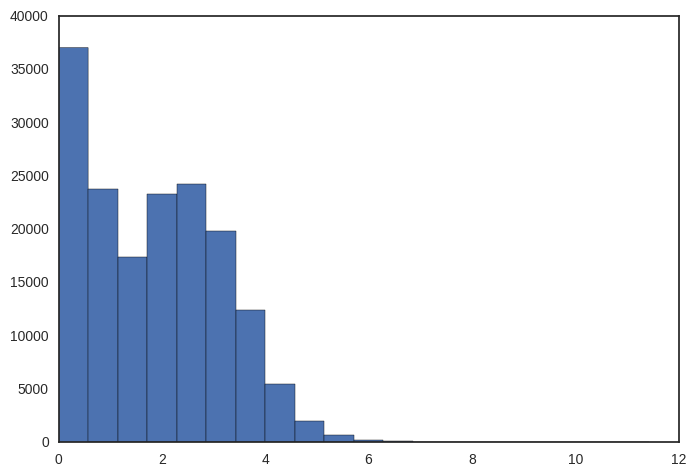

In [35]:
plt.hist(programs['time_log'], bins=20)
plt.show()

#### Úkol 1b: Porovnání dvou úloh
K dispozici máš histogram porovnávající čas řešení dvou úloh. Tentokrát je kód trochu složitější, protože zobrazujeme 2 histogramy v jednom grafu.
1. Uprav graf tak, aby zobrazoval časy řešení správných vs. špatných řešení (pro úlohu `task1`)

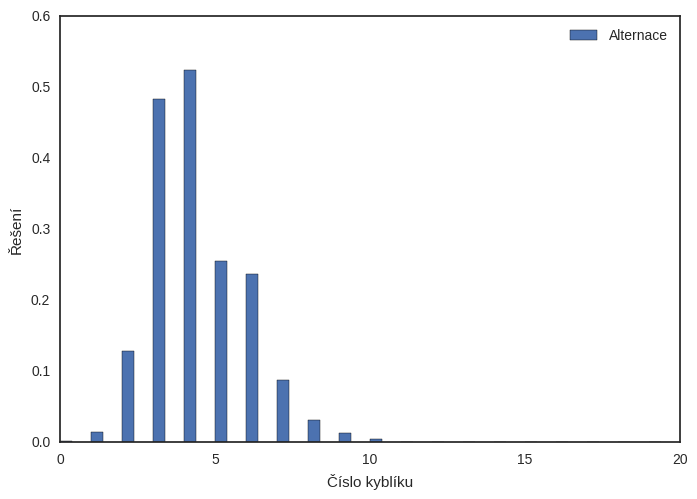

<function __main__.plot_histogram>

In [36]:
def plot_histogram(task1, task2, bin_count=20):
    # Histrogram se da zobrazit mnohem jednoduseji,
    # ale zde chceme porovnat dve ulohy v jednom grafu.
    
    # nejprve profiltrujeme data na pozadovane 2 ulohy
    data = programs[programs['problem_name'].isin({task1, task2})]
    # take je potreba se zbavit chybnych zaznamu
    data = data[data['time'] > 0]
    # pro kazdou ulohu si napocitame histogram,
    # a pak jej vykreslime
    for i, (task, task_data) in enumerate(data.groupby('problem_name')):
        # vypocet histogramu
        hist, bins = np.histogram(task_data['time_log'], bins=bin_count, normed=True)
        # vykresleni histogramu
        plt.bar(
            np.arange(0, len(hist)) + 0.4 * i,
            hist,
            width=0.4,
            color=sns.color_palette()[i * 2],
            label=task
        )
    plt.xlabel('Číslo kyblíku')
    plt.ylabel('Řešení')
    plt.legend(loc='upper right')
    plt.show()

# nasleduje kod, ktery vytvari interaktivni prvky
task1 = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='První úloha:',
    disabled=False
)
task2 = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='Druhá úloha:',
    disabled=False
)
bin_count = widgets.IntSlider(value=20, min=5, max=50, description="Počet kyblíků")
widgets.interact(plot_histogram, task1=task1, task2=task2, bin_count=bin_count)

### Úkol 2: Porovnání všech úloh pomocí scatter plotu

Dále nás mohou zajímat vztahy některých proměnných mezi sebou. Pro tento účel můžeme použít několik typů grafů, asi nejznáměnším je tzv. scatter plot. Často se stává, že počet vykreslovaných bodů činí tento typ grafu nepřehledným. Jedna z technik, jak se tomu vyhnout, je si z dat vybrat pouze menší náhodný vzorek.

K dispozici máš graf znázorňující několik vlastností úloh:
- počet řešitelů (velikost bublinek)
- medián času řešení (osa X)
- úspěšnost (osa Y)
- míra potřeby rekurze (medián maximální hloubky rekurze u správných řešení) (barva)

Graf si prostuduj a:
1. Zaměň reprezentaci různých proměnných - změní se nějak interpretace dat?
1. Vytvoř podobný graf z pohledu uživatelů. Proměnné jsou:
 - počet vyřešených úloh
 - úspěšnost
 - medián času řešení
 - použití rekurze
 

<function __main__.plot_scatter>

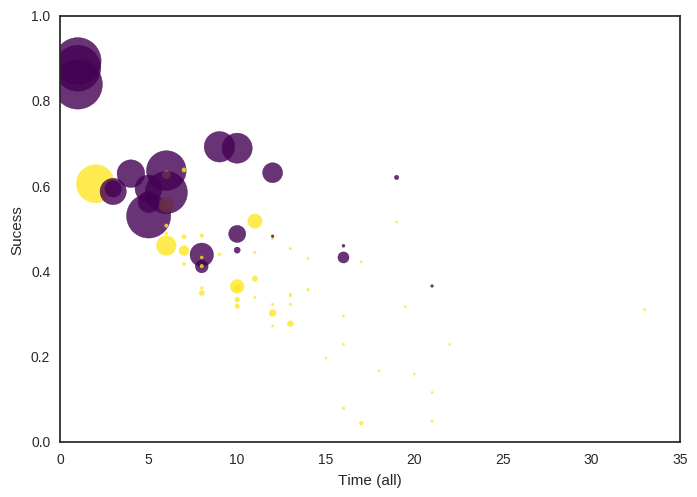

In [40]:
def plot_scatter(sample_size):
    data = problems[problems['problem_name'].isin(random.sample(list(programs['problem_name'].unique()), sample_size))]
    size = 2 + np.pi * (20 * data['users'] / data['users'].max()) ** 2
    cmap = get_cmap('viridis')
    plt.scatter(data['time_all'], data['success'], s=size, color=cmap(data['recursion_correct']), alpha=0.8)
    plt.xlabel('Time (all)')
    plt.ylabel('Sucess')
    plt.ylim(0, 1)
    plt.xlim(0, plt.xlim()[1])
    
problem_count = len(programs['problem_id'].unique())
sample_size = widgets.IntSlider(min=10, max=problem_count, value=problem_count, description='Velikost vzorku')
widgets.interact(plot_scatter, sample_size=sample_size)

### Úkol 3: Porovnání proměnných pomocí pair gridu

Další způsob, jak vizualizovat vztah (většího) počtu proměnných je tzv. pair grid. Tento graf má 3 oblasti, které můžeme ovlivnit - diagonála (typicky se používá pro histogram hodnot pro danou proměnnou) a oblast nad/pod diagonálou.

K dispozici máš graf znázorňující stejná data jako graf v předchozím příkladu.
1. Má tento graf oproti scatter plotu nějaké výhody/nevýhody?
1. Uprav graf tak, aby znázorňoval vztah proměnných týkajících se uživatelů (podobně jako v předchozím příkladu).

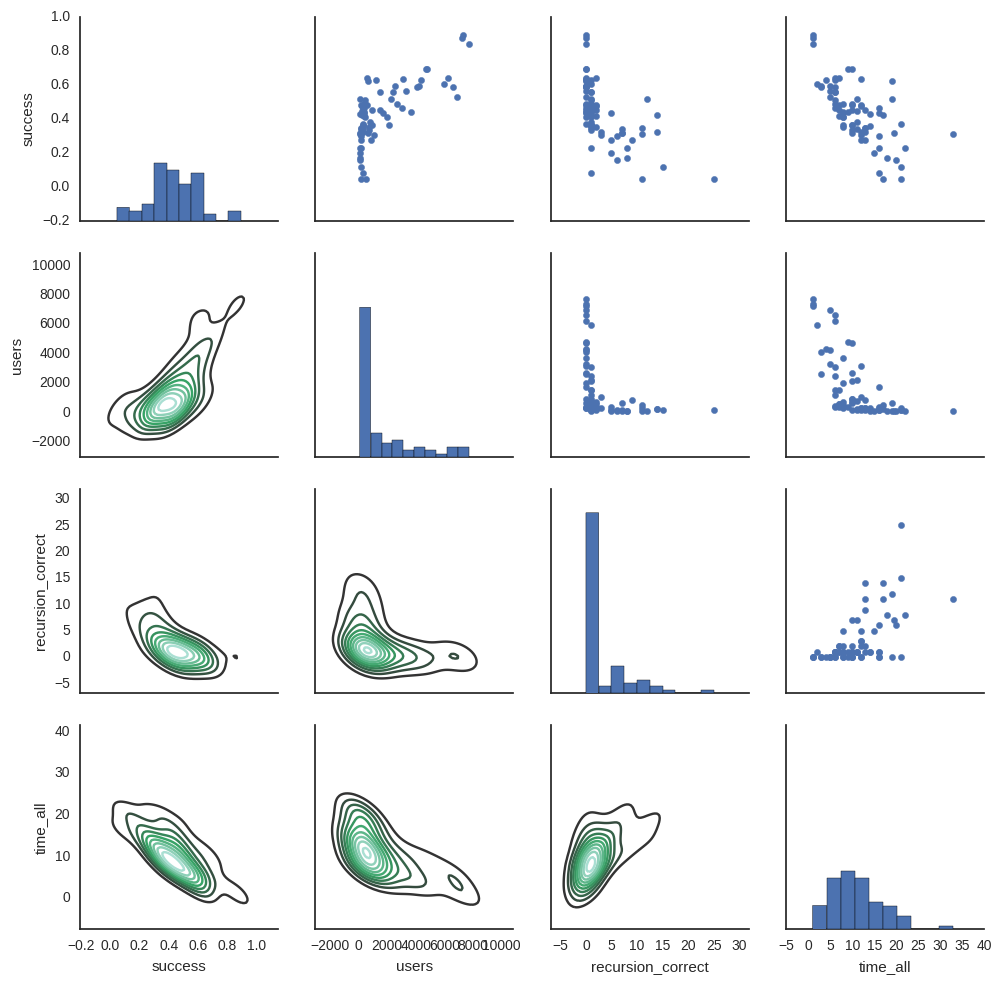

In [41]:
g = sns.PairGrid(problems[['success', 'users', 'recursion_correct', 'time_all']])
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)

### Úkol 4: Porovnání několika úloh pomocí violinplotu

Pokud chceme porovnat distribuci hodnot pro více kategorí, hodí se nám k tomu [boxplot](https://cs.wikipedia.org/wiki/Boxplot) a ještě lépe violin plot. 

K dipozici máš graf znárojňující distribuci času pro správná a špatná řešení u 5 náhodně vybraných úloh.
1. Seznam se s grafem a zkus mu porozumět.
1. Uprav graf tak, aby místo času řešení ukazoval počet spuštění/pokusů v rámci jedné hry.

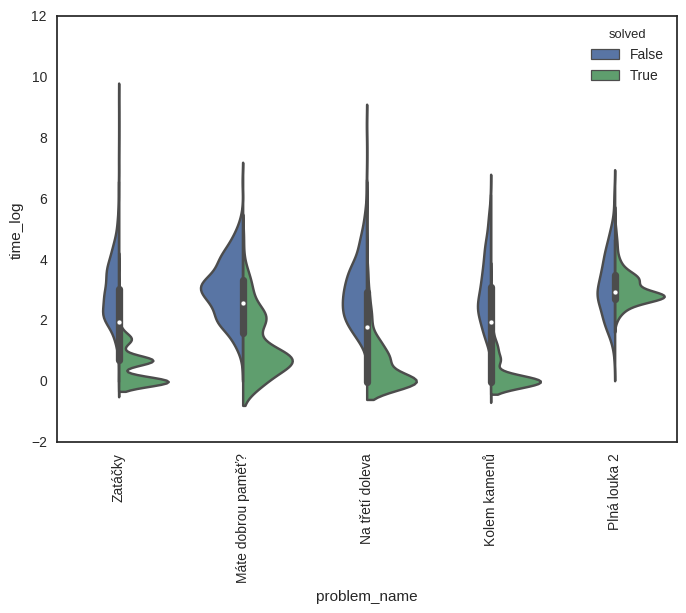

In [42]:
to_plot = programs[programs['problem_name'].isin(random.sample(list(programs['problem_name'].unique()), 5))]
sns.violinplot(x='problem_name', y='time_log', hue='solved', split=True, data=to_plot)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### Ukázka 5: Navštívená pole

Následuje ukázka pokročilejší analýzy, kdy se za použití odsimulovaných programů koukáme na to, jaká pole jsou v rámci jedné úlohy nejnavštěvovanější (pro správna a špatná řešení).

/home/xpapous1/.virtualenvs/data-science-workshop/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<function __main__.plot_heatmap>

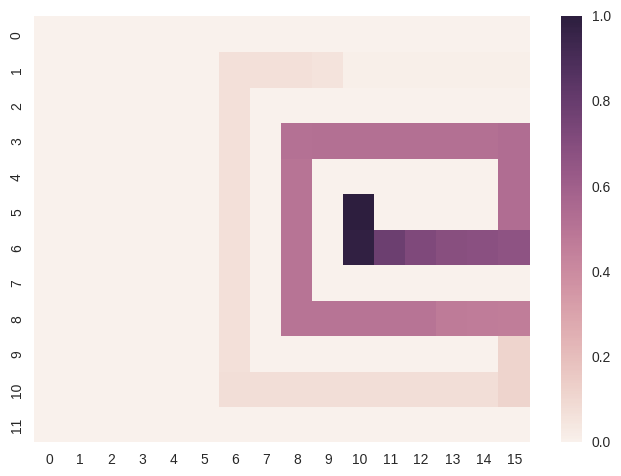

In [43]:
def plot_heatmap(task, correct=True):
    data = programs[programs['problem_name'] == task]
    data = data[data['solved'] == correct]
    visited_matrix = np.zeros((12, 16))
    for visited in data['visited'].values:
        for row, col in visited:
            visited_matrix[row, col] += 1
    sns.heatmap(visited_matrix / visited_matrix.max())

# nasleduje kod, ktery vytvari interaktivni prvky
task = widgets.Select(
    options=sorted(programs['problem_name'].unique()),
    description='Úloha:',
    disabled=False
)
correct = widgets.Checkbox(description='Správná řešení')
widgets.interact(plot_heatmap, task=task, correct=correct)

<div style="
    width: 100%;
    height: 10px;
    background-color: black;
"></div>

## Strojové učení

Pokusíme se predikovat čas řešení úlohy na základě časů řešeních jiných úloh. Použijeme k tomu *lineární regresi*, což je jednoduchý model, který předpokládá lineární závislost mezi odhadovanou proměnnou a vstupními hodnotami. Mezi všem možnými linárními funkcemi zvolí tu, která minimalizuje průměrnou čtvercovou chybu, tj. průměr druhých mocnnin rozdílů mezi pozorovanými a předpovídanými hodnotami.

Lineární regresi si napřed ukážeme na malém vzorku umělých dat, která si náhodně vygenerujeme:

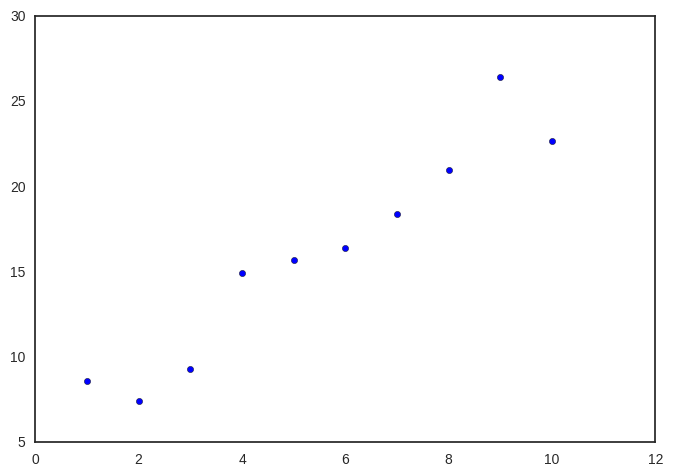

In [44]:
n = 10                               # n = pocet bodu
x = np.linspace(1, 10, num=n)        # x = 1, 2, ..., 10
noise = np.random.normal(0, 1.5, n)  # noise = normalni rozdeleni se stredem 0 a smerodatnou odchylkou 1.5
y = 5 + 2 * x + noise                # y = primka + sum
plt.scatter(x, y)

### Úkol 6: Nalezení nejlepší přímky

Hledáme tedy přímku s nejmenší průměrnou čtvercovou chybou (průměr z druhých mocnin rozdílů mezi pozorovanými a předpovídanými hodnotami). Následující graf zobrazuje pro zvolenou přímku tutu průměrnou čtvercovou chybu.

- Vyzkoušejte různé hodnoty pro *a* a *b* a sledujte, jak se chyba mění.
- Najděte přímku s nejmenší chybou.

Predicted line: y = 1.00x + 0.00
Error = 123.211465546


<function __main__.plot_line>

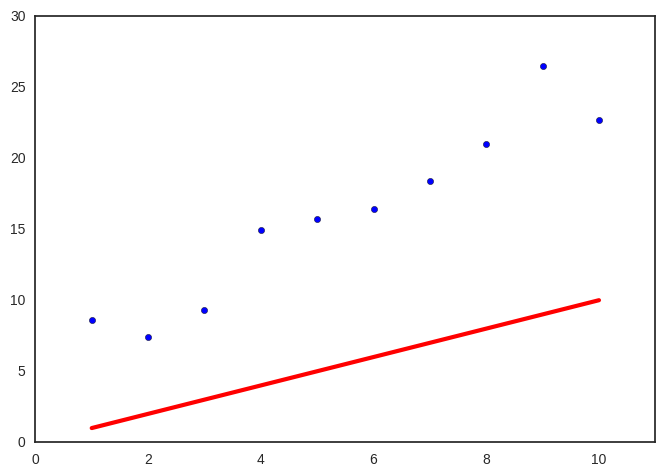

In [45]:
def plot_line(a, b):
    print('Predicted line: y = {a:.2f}x + {b:.2f}'.format(a=a, b=b))
    # Vypocitame vektor predpovedi pro kazdou hodnotu x (operace se
    # aplikuje na kazdy bod vektoru x, vysledkem je opet vektor)
    y_predictions = x * a + b
    # Pro vypocet prumerne ctvercove chyby pouzijeme funkci
    # mean_squared_error z importovaneho modulu sklearn.metrics
    print('Error =', mean_squared_error(y, y_predictions))
    # Vykresleni namerenych bodu
    plt.scatter(x, y)
    # Vykresleni primky
    plt.plot(x, y_predictions, color='red', linewidth=3)
    plt.xlim([0, 11])
    plt.ylim([0, 30])
    
a = widgets.IntSlider(min=0, max=10, value=1)
b = widgets.IntSlider(min=0, max=10, value=0)
widgets.interact(plot_line, a=a, b=b)

### Knihovna scikit-learn pro strojové učení

Abychom nemuseli hledat nejlepší přímku ručně, nastal čas nasadit strojové učení! Knihovna `sklearn` nabízí model pro lineární regresi `linear_model.LinearRegression` s metodou `fit` pro naučení modelu ze zadaných dat.

Predicted line: y = 2.00x + 5.10
Error = 3.03323068537
Predictions: [[  7.10038648]
 [  9.09645095]
 [ 11.09251541]
 [ 13.08857987]
 [ 15.08464434]
 [ 17.0807088 ]
 [ 19.07677327]
 [ 21.07283773]
 [ 23.0689022 ]
 [ 25.06496666]]


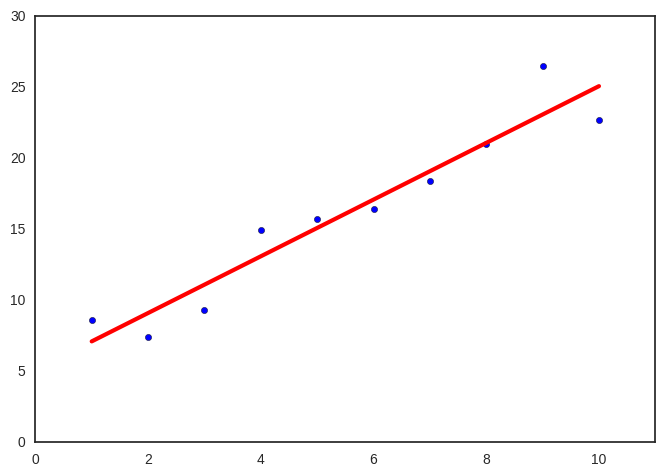

In [46]:
# Technikalie: potrebujeme matice n x 1 misto vektoru delky n
x = x.reshape(n, 1)
y = y.reshape(n, 1)

# Vytvorime linearni model
model = linear_model.LinearRegression()
# Naucime model z dat - tady je to misto, kde se deje magie (= matika)!
model.fit(x, y)

# Zobrazeni vysledku (pomoci funkce plot_line definovane vyse)
plot_line(a=model.coef_[0][0], b=model.intercept_[0])

# Ukazka predpovedi pomoci natrenovaneho modelu
y_predictions = model.predict(x)
print('Predictions:', y_predictions)

### Předpovídání času řešení

Nyní se pokusíme aplikovat tento lineární model pro předpovídání časů řešení. Z času řešení jedné úlohy budeme chtít předpovědět čas řešení jiné úlohy. Napřed se podívejme na data, se kterými budeme pracovat.

In [47]:
# Nacteme matici, ktera pro kazdou dvojici uzivatel-problem udava cas reseni
times = pd.read_csv('data/robotanik-user-problem-time.csv', index_col=0)
# Mame kolem 9000 uzivatelu (radky) a 80 uloh (sloupce)
times.shape

(9161, 78)

In [48]:
# Prvnich par radku matice vypada takto
# (NaN = "not a number" - uzivatel danou ulohu neresil/nevyresil)
times.head()

,635,636,637,638,639,640,641,642,643,644,...,1402,1403,1404,1405,1406,1407,1704,1705,1706,1707
user_id,,,,,,,,,,,,,,,,,,,,,
1,25.0,13.0,14.0,38.0,NaN,459.0,NaN,NaN,NaN,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,5.0,49.0,19.0,92.0,23.0,57.0,40.0,42.0,211.0,...,NaN,NaN,NaN,NaN,NaN,NaN,185.0,113.0,36.0,73.0
4,26.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,52.0,39.0,25.0,19.0,364.0,25.0,99.0,NaN,56.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,68.0,20.0,32.0,18.0,NaN,42.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Budeme pracovat s logartimy casu
times = times.apply(np.log)
# Omezime se na prvnich 11 uloh
times = times[[str(problem_id) for problem_id in range(635, 646)]]
# Vyfiltrujeme pouze ty resitele, kteri vyresili vsech 11 uloh
times = times.dropna()
# Mame zhruba 300 studentu, kteri vsech techto 11 uloh vyresilo
print(times.shape)
times.head()

(322, 11)


,635,636,637,638,639,640,641,642,643,644,645
user_id,,,,,,,,,,,
2,2.302585,1.609438,3.891820,2.944439,4.521789,3.135494,4.043051,3.688879,3.737670,5.351858,3.931826
9,3.401197,2.564949,3.737670,3.828641,6.363028,4.330733,5.398163,5.476464,5.273000,4.343805,6.148468
11,3.988984,2.197225,3.178054,3.332205,4.454347,3.218876,6.556778,7.053586,4.204693,5.513429,4.430817
41,5.056246,2.079442,3.496508,2.833213,5.220356,3.828641,5.978886,6.293419,5.181784,4.304065,4.753590
44,5.298317,2.564949,3.433987,2.484907,4.521789,3.367296,3.637586,5.153292,5.123964,6.712956,4.934474


### Úkol 7: Lineární regrese pro čas řešení

Napřed si vyzkoušíme jednodimenzionální lineární regresi jako v ukázce s umělými daty výše. Budeme předpovídat čas řešení úlohy 645 (Alternace) z času řešení úlohy 639 (Cik cak).

1. Vykreslete body všechny (x, y) = (čas Alternace, čas Cik cak) (funkce `plt.scatter`)
2. Najděte nejlepší přímku (model `linear_model.LinearRegression` a jeho metoda `fit`)
3. Vypočítejte předpovědi časů úlohy Cik cak (`model.predict(x)`)
4. Vykreslete přímku předpovědí (funkce `plt.plot`)

In [50]:
# x musi byt matice (n x 1), y vektor delky n
n = len(times)
x = times['639'].values.reshape(n, 1)
y = times['645'].values

In [51]:
# Doplnte: vykresleni vsech bodu, natrenovani linearniho modelu, vykresleni primky

Zjistěte průměrnou čtvercovou chybu nalezené přímky a pokuste se ji interpretovat (co to říká o vztahu mezi skutečnými a předpovídanými časy, nezapomeňte přitom, že pracujeme s logaritmy časů):

In [52]:
error = 0 # doplnte
print('Error =', error)

Error = 0


### Úkol 8: Vícedimenzionální lineární regrese

Teď budeme k predikci času 11. úlohy využívat časy prvních 10 úloh. Natrénujte lineární model a zjistěte, jestli takový model dosáhne menší čtvercové chyby.

In [53]:
# Budeme predikovat cas 11. ulohy z casu prvnich 10 uloh
m = 10
# Matice x ted bude mit rozmery n x m, y stale n x 1
x = times[[str(problem_id) for problem_id in range(635, 635+m)]].values.reshape(n, m)
y = times['645'].values

In [54]:
# Doplnte: natrenovani linearniho modelu, vypocet predpovedi, vypocet ctvercove chyby

### Úkol 9: Nelineární modely

Vztah mezi časy řešení různých úloh nemusí být lineární. Lepších přepdovědí bychom tedy mohli dosáhnout použitím nelineárního modelu. Takových je celá řada, ukážeme si aspoň jeden z nich, SVM (*Support Vector Machines*), který v knihovně `sklarn` vytvoříme pomocí `svm.SVR()` a dále s ním pracujeme úplně stejně jako s lineárním modelem (má m metody `fit` a `predict`)

In [55]:
model = svm.SVR()
# Doplnte: natrenovani modelu, vypocet predikci, vypocet ctvercove chyby

### Úkol 10: Podvody

Jaká by byla kvalita našich natrénovaných modelů, kdybychom je použili na nová, dosud neviděná data, tj. pokud bychom chtěli předpovídat časy řešení pro řešitele, kteří ještě úlohu Cik cak nevyřešili?

Čtvercová chyba, kterou jsme počítali je ve skutečnosti zřejmě dost optimistických odhadem skutečné chyby. Proč to tak je? Kde jsme "podváděli" a co bychom mohli udělat jinak, aby byl náš odhad chyby na nových datech realistický? Jaké další nevýhody náš model má a co by se s tím dalo dělat?